In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error

In [2]:
# prompt: unzip zip file

!unzip /content/archive_5.zip


Archive:  /content/archive_5.zip
  inflating: kalimati_tarkari_dataset.csv  


In [8]:
# read the dataset
Data=pd.read_csv("/content/kalimati_tarkari_dataset.csv")
Data.head(-1)


,SN,Commodity,Date,Unit,Minimum,Maximum,Average
0,0,Tomato Big(Nepali),2013-06-16,Kg,35.0,40.0,37.5
1,1,Tomato Small(Local),2013-06-16,Kg,26.0,32.0,29.0
2,2,Potato Red,2013-06-16,Kg,20.0,21.0,20.5
3,3,Potato White,2013-06-16,Kg,15.0,16.0,15.5
4,4,Onion Dry (Indian),2013-06-16,Kg,28.0,30.0,29.0
...,...,...,...,...,...,...,...
197155,197155,Garlic Dry Chinese,2021-05-13,Kg,240.0,250.0,245.0
197156,197156,Garlic Dry Nepali,2021-05-13,Kg,100.0,120.0,110.0
197157,197157,Fish Fresh(Rahu),2021-05-13,KG,270.0,280.0,275.0
197158,197158,Fish Fresh(Bachuwa),2021-05-13,KG,225.0,235.0,230.0


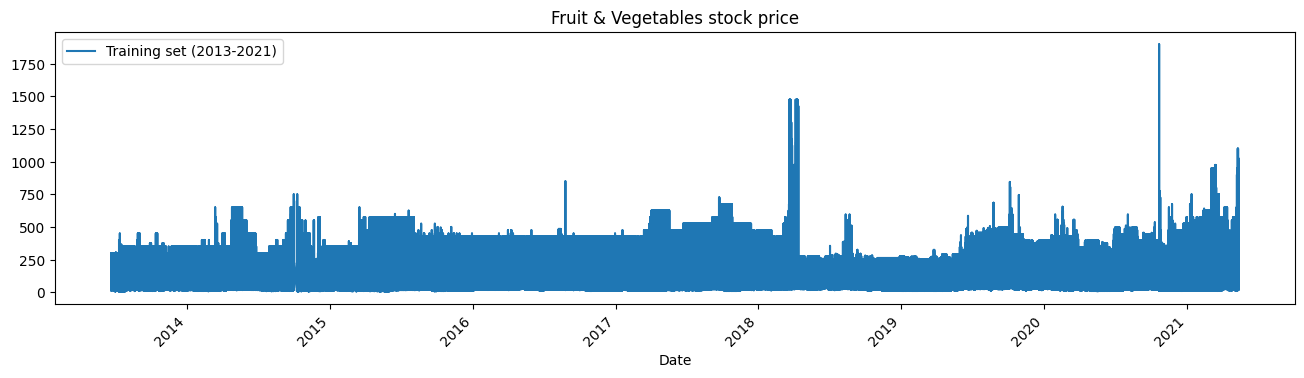

In [9]:
# Convert the 'Date' column to datetime if it's not already
if Data['Date'].dtype != 'datetime64[ns]':
    Data['Date'] = pd.to_datetime(Data['Date'])


# Set the 'Date' column as the index
Data.set_index('Date', inplace=True)

#Plotting
plt.figure(figsize=(10, 5))
Data['Average']['2013-6-20':'2021-07-25'].plot(figsize=(16, 4), legend=True)
plt.xticks(rotation=45)
plt.legend(['Training set (2013-2021)'])
plt.title('Fruit & Vegetables stock price')
plt.show()

In [10]:
Train_set = Data.loc['2013-03-10':'2020-07-25', 'Average'].values # Use .loc to slice by dates
Test_set = Data.loc['2020-07-25':, 'Average'].values
S=MinMaxScaler(feature_range=(-1,1))
scaled_train = S.fit_transform(Train_set.reshape(-1,1))
scaled_test = S.transform(Test_set.reshape(-1,1))

In [11]:
#Handling Sequential Dependencies
Test_set_to_prediction=np.concatenate([scaled_train[-21:],scaled_test],axis=0)

In [12]:
window_size = 5
def windowed_dataset(series,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series.reshape(-1,1))
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(len(series)).prefetch(1)
    return dataset

In [13]:
X,y=np.array(list(windowed_dataset(scaled_train,10))[0][0]),np.array(list(windowed_dataset(scaled_train,10))[0][1])


In [14]:
X_test,y_test=np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][0]),np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][1])


In [15]:
##Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(60, input_shape=(X.shape[1], 1), return_sequences=True),
    tf.keras.layers.GRU(50, return_sequences=True),
   (tf.keras.layers.GRU(30, return_sequences=True)),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(10),
    tf.keras.layers.Dense(1)])


# Set the training parameters
model_gru.compile(optimizer = "adam",loss='mean_squared_error')

# Print the model summary
model_gru.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 5, 60)               │          11,340 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 5, 50)               │          16,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 5, 30)               │           7,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 5, 20)               │           3,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 10)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,611 (154.73 KB)

 Trainable params: 39,611 (154.73 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [23]:
callbacks = myCallback()
history1= model_gru.fit(X,y,epochs=10,callbacks=[early_stopping], verbose = 2)

Epoch 1/10
5357/5357 - 90s - 17ms/step - loss: 0.0072
Epoch 2/10
5357/5357 - 87s - 16ms/step - loss: 0.0066
Epoch 3/10
5357/5357 - 142s - 27ms/step - loss: 0.0061
Epoch 4/10
5357/5357 - 87s - 16ms/step - loss: 0.0058
Epoch 5/10
5357/5357 - 142s - 26ms/step - loss: 0.0056
Epoch 6/10
5357/5357 - 142s - 27ms/step - loss: 0.0061
Epoch 7/10
5357/5357 - 142s - 26ms/step - loss: 0.0054
Epoch 8/10
5357/5357 - 87s - 16ms/step - loss: 0.0051
Epoch 9/10
5357/5357 - 143s - 27ms/step - loss: 0.0050
Epoch 10/10
5357/5357 - 141s - 26ms/step - loss: 0.0049


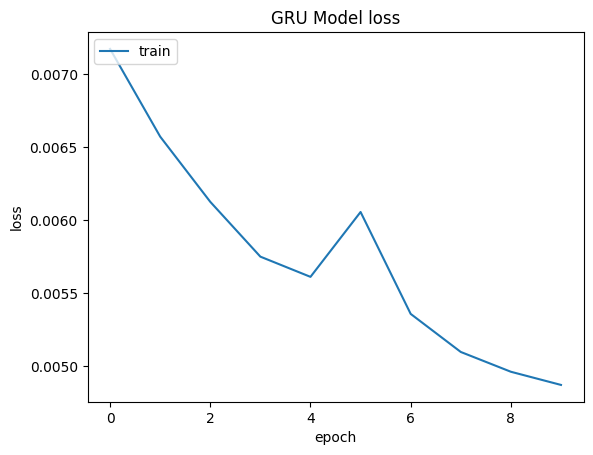

In [24]:
plt.plot(history1.history['loss'])
plt.title('GRU Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [25]:
model_gru.evaluate(X_test,y_test)

807/807 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0140


0.016019774600863457

In [26]:
FIN_gru=model_gru.predict(X_test)

807/807 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


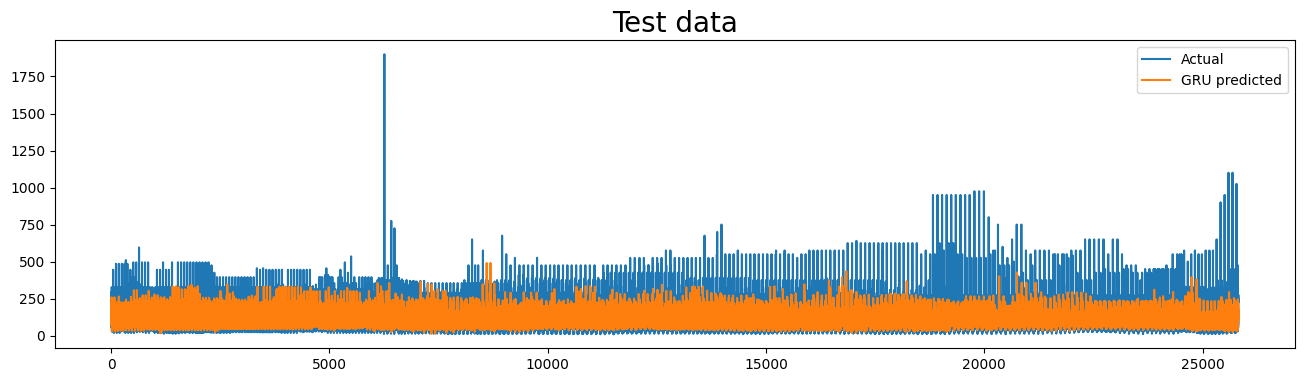

In [27]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.title("Test data",fontsize=20)
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(FIN_gru),label="GRU predicted")
plt.legend()
plt.show()

In [28]:
# calculate the similer between the predicted and actual data

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming FIN_gru and y_test are already defined from your previous code
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, FIN_gru))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, FIN_gru)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate R-squared
r2 = r2_score(y_test, FIN_gru)
print(f'R-squared (R2): {r2}')

Root Mean Squared Error (RMSE): 0.12656925570573094
Mean Absolute Error (MAE): 0.07800217209290973
R-squared (R2): 0.07877022918383081


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

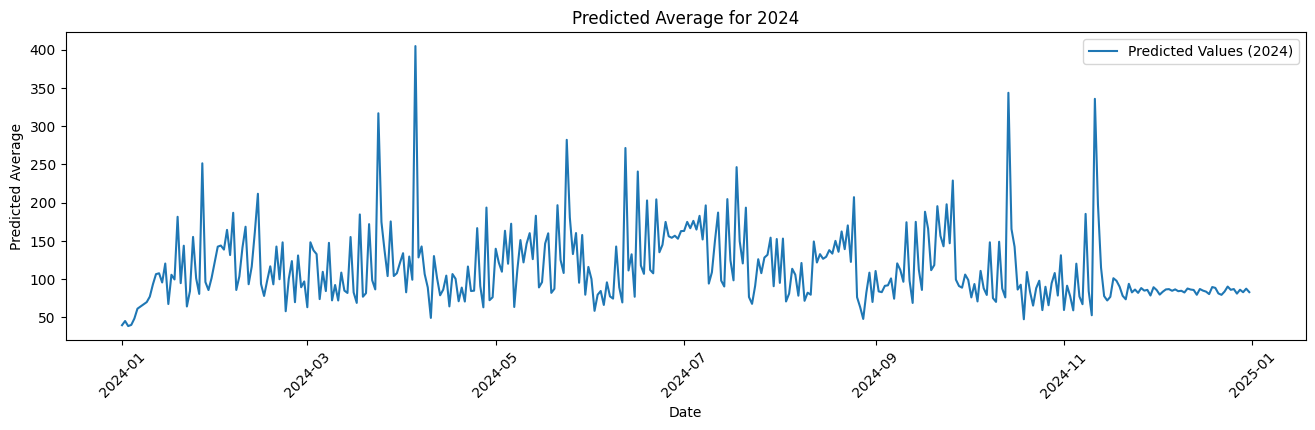

In [31]:
# prompt: plot the predicted vlaues on the new year

# Assuming 'Data' DataFrame and 'model_gru' are already defined from the previous code.
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming you want to predict for the entire year 2024
# Create a date range for 2024
future_dates = pd.date_range(start='2024-01-01', end='2024-12-31')

# Prepare the input data for prediction
last_window = Test_set_to_prediction[-5:]  # Use the last 5 data points for prediction

# Create a list to store future prediction values
predicted_values = []
for i in range(len(future_dates)):
  next_prediction = model_gru.predict(last_window.reshape(1, -1, 1))
  predicted_values.append(next_prediction[0,0])
  last_window = np.append(last_window[1:],next_prediction)

# Inverse transform to get actual values
predicted_values = S.inverse_transform(np.array(predicted_values).reshape(-1,1))

# Create a DataFrame for plotting
future_data = pd.DataFrame({'Date': future_dates, 'Predicted': predicted_values.flatten()})
future_data = future_data.set_index('Date')

# Plot the predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.plot(future_data.index, future_data['Predicted'], label='Predicted Values (2024)')
plt.xlabel('Date')
plt.ylabel('Predicted Average')
plt.title('Predicted Average for 2024')
plt.legend()
plt.xticks(rotation=45)
plt.show()